In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
import scipy.signal
import pywt # For Wavelet Transform
from scipy.fft import fft, fftfreq
import torch.optim as optim

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Data for c maps'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define column names
cols = ['unit', 'cycle', 'os1', 'os2', 'os3'] + [f's{i}' for i in range(1, 22)]

# Load Data directly from your Drive folder
train_df = pd.read_csv(os.path.join(data_path, 'train_FD001.txt'), sep=r'\s+', header=None, names=cols)
test_df = pd.read_csv(os.path.join(data_path, 'test_FD001.txt'), sep=r'\s+', header=None, names=cols)
truth_df = pd.read_csv(os.path.join(data_path, 'RUL_FD001.txt'), sep=r'\s+', header=None, names=['RUL'])

print("Data Loaded Successfully from Drive!")
print(f"Train Shape: {train_df.shape}")
print(train_df.describe(include='all'))
train_df.head()

Data Loaded Successfully from Drive!
Train Shape: (20631, 26)
               unit         cycle           os1           os2      os3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

                 s1            s2            s3            s4            s5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053 

,unit,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Plotting Raw Sensor Data for Unit 1...


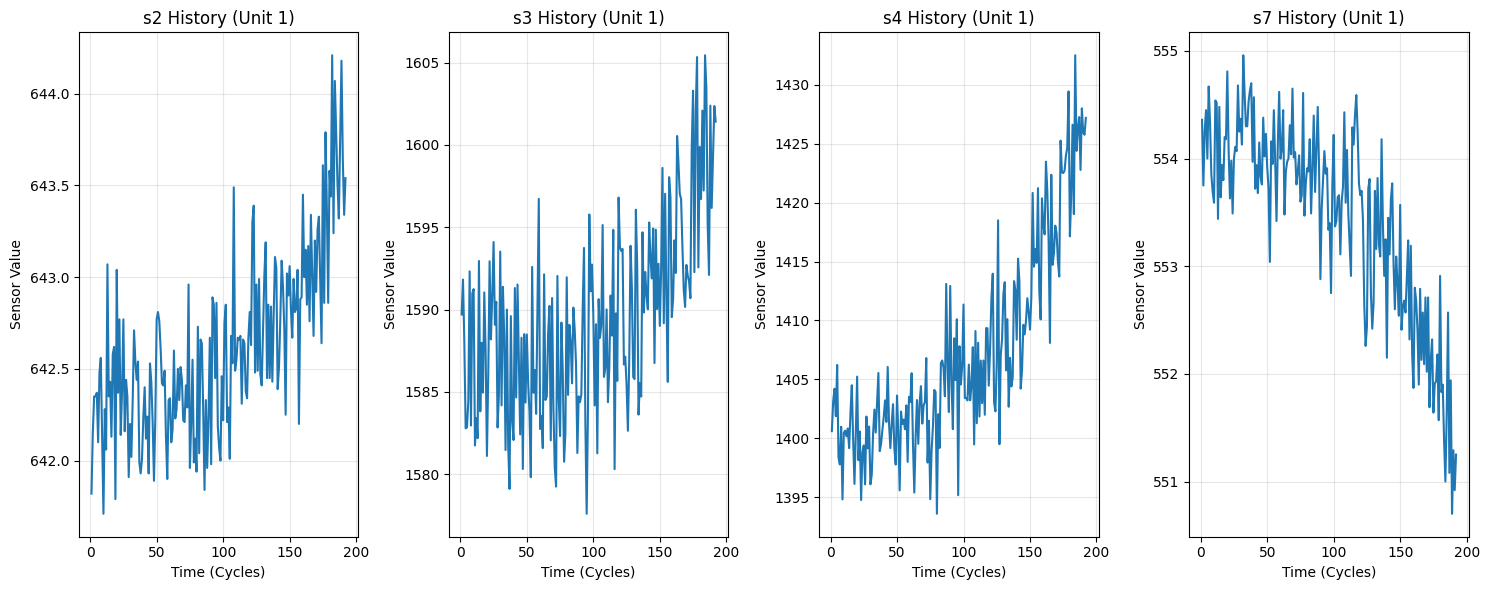

In [ ]:
def plot_sensor_history(unit_id, sensor_list):
    # Extract data for the specific unit
    unit_data = train_df[train_df['unit'] == unit_id]

    plt.figure(figsize=(15, 6))
    for i, sensor in enumerate(sensor_list):
        plt.subplot(1, len(sensor_list), i+1)
        plt.plot(unit_data['cycle'], unit_data[sensor])
        plt.title(f'{sensor} History (Unit {unit_id})')
        plt.xlabel('Time (Cycles)')
        plt.ylabel('Sensor Value')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Plotting Raw Sensor Data for Unit 1...")
# We plot a few key sensors to visually inspect the "Run-to-Failure" pattern
# s2, s3, s4 are usually highly correlated with degradation
plot_sensor_history(unit_id=1, sensor_list=['s2', 's3', 's4', 's7'])

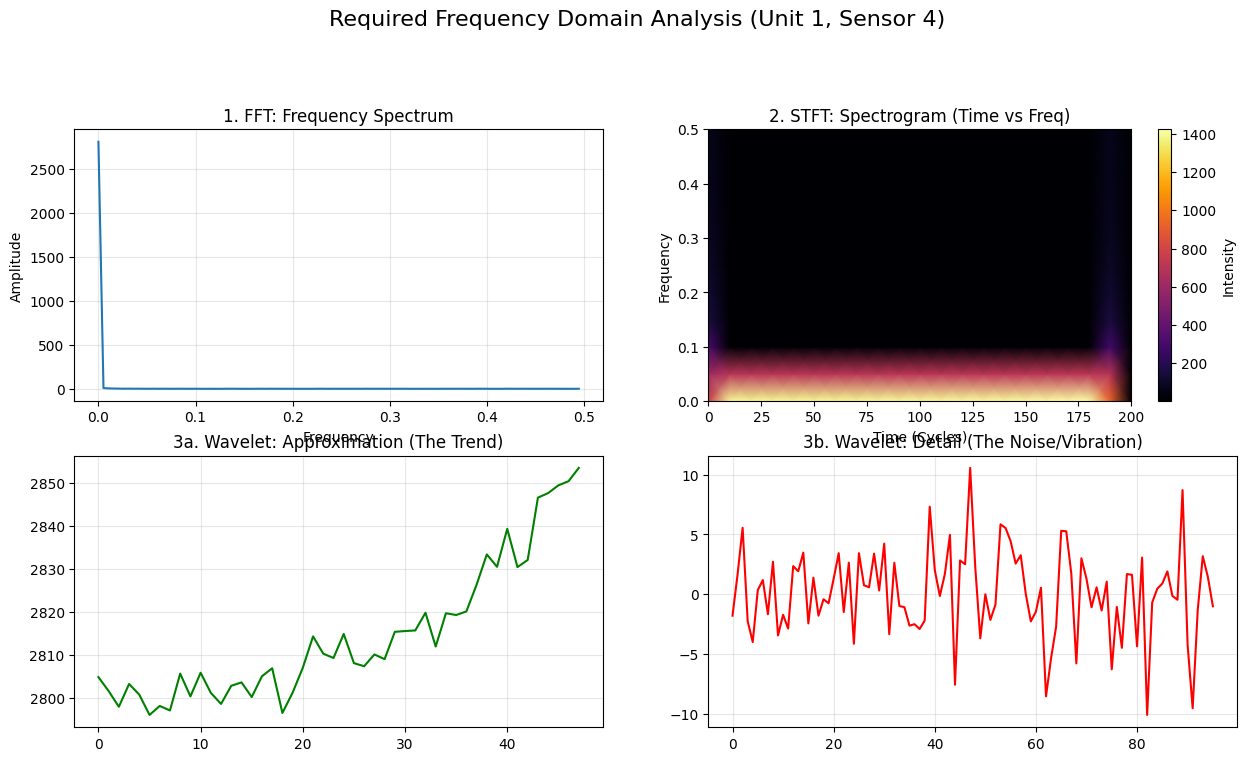

In [ ]:

train_df['max_cycle'] = train_df.groupby('unit')['cycle'].transform('max')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

unit_data = train_df[train_df['unit'] == 1]
# We analyze Sensor 4 (High Pressure Turbine Temperature) - A critical sensor
signal = unit_data['s4'].values
cycles = unit_data['cycle'].values

plt.figure(figsize=(15, 12))
plt.suptitle('Required Frequency Domain Analysis (Unit 1, Sensor 4)', fontsize=16)

# ==========================================
# 1. FFT (Fast Fourier Transform)
# ==========================================
# Tells us the dominant "rates of change" in the signal
N = len(signal)
T = 1.0 # Sample spacing (1 cycle)
yf = fft(signal)
xf = fftfreq(N, T)[:N//2]

plt.subplot(3, 2, 1)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('1. FFT: Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

# ==========================================
# 2. STFT (Short-Time Fourier Transform)
# ==========================================
# Visualizes how signal frequency content changes OVER TIME (as engine degrades)
f, t, Zxx = scipy.signal.stft(signal, fs=1.0, nperseg=20)

plt.subplot(3, 2, 2)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='inferno')
plt.title('2. STFT: Spectrogram (Time vs Freq)')
plt.ylabel('Frequency')
plt.xlabel('Time (Cycles)')
plt.colorbar(label='Intensity')

# ==========================================
# 3. WT (Wavelet Transform)
# ==========================================
# Decomposes signal into "Approximation" (Trend) and "Detail" (Noise)
coeffs = pywt.wavedec(signal, 'db1', level=2)
cA2, cD2, cD1 = coeffs

plt.subplot(3, 2, 3)
plt.plot(cA2, color='green')
plt.title('3a. Wavelet: Approximation (The Trend)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(cD1, color='red')
plt.title('3b. Wavelet: Detail (The Noise/Vibration)')
plt.grid(True, alpha=0.3)

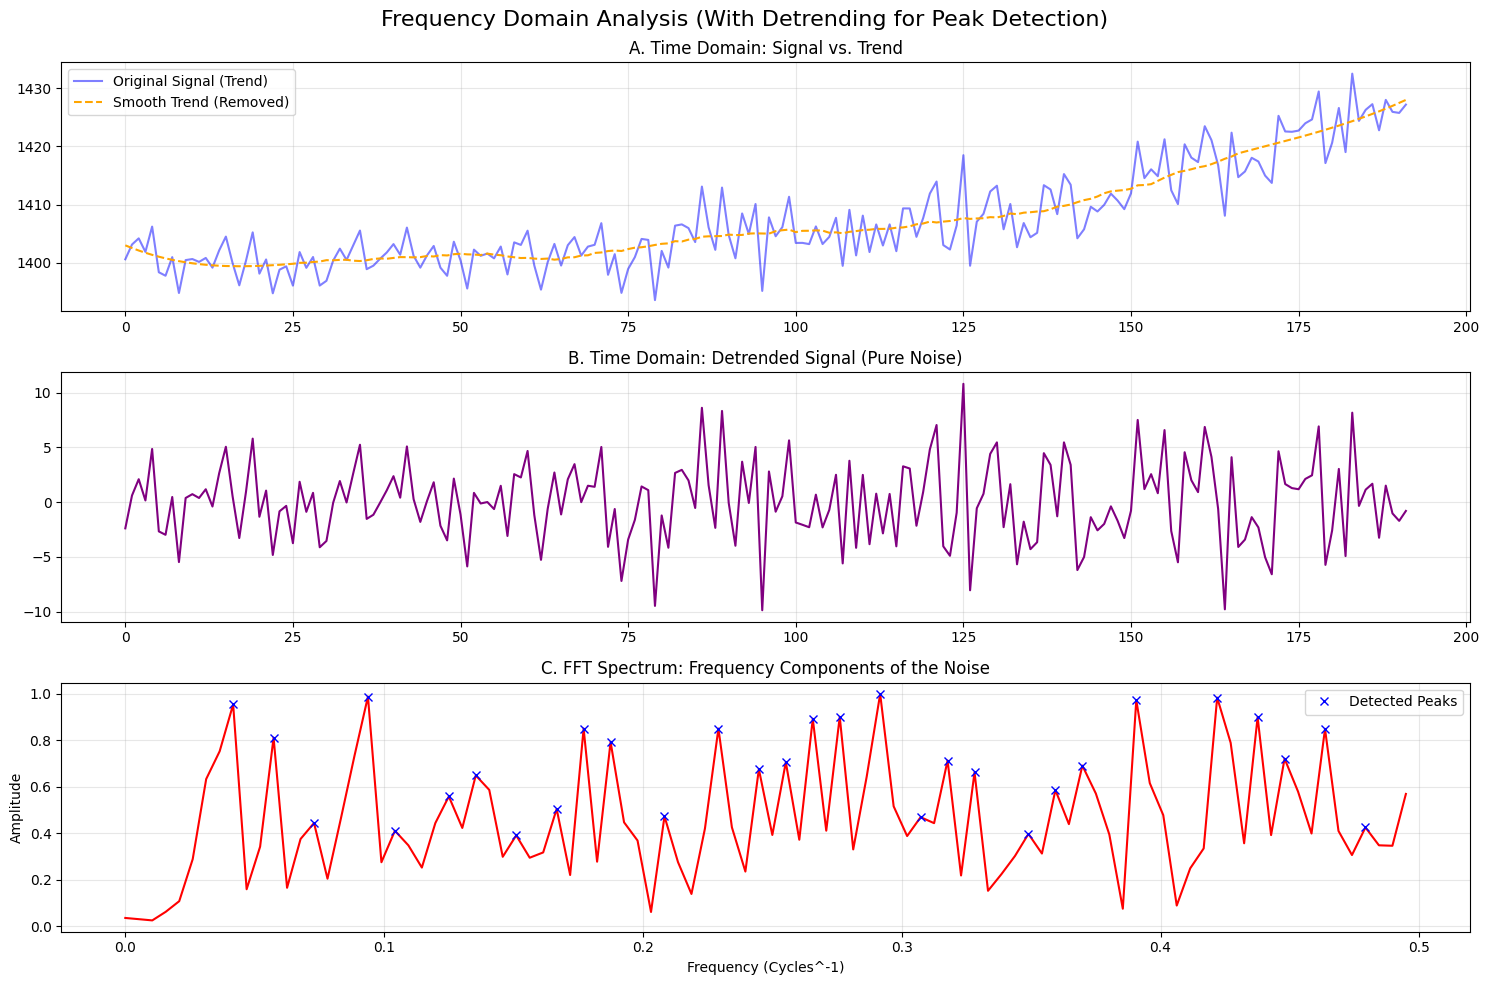

In [ ]:
unit_data = train_df[train_df['unit'] == 1]
# We use Sensor 4 again
raw_signal = unit_data['s4'].values

# THE TRICK: Remove the "Trend" to see the "Spikes"
# We subtract the smooth moving average to leave only the "high frequency" noise
smooth_trend = scipy.signal.savgol_filter(raw_signal, window_length=51, polyorder=3)
detrended_signal = raw_signal - smooth_trend

plt.figure(figsize=(15, 10))
plt.suptitle('Frequency Domain Analysis (With Detrending for Peak Detection)', fontsize=16)

# Plot A: Raw vs Trend (Visualizing what we are removing)
plt.subplot(3, 1, 1)
plt.plot(raw_signal, label='Original Signal (Trend)', color='blue', alpha=0.5)
plt.plot(smooth_trend, label='Smooth Trend (Removed)', color='orange', linestyle='--')
plt.title('A. Time Domain: Signal vs. Trend')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: The Detrended Signal (The "Noise")
plt.subplot(3, 1, 2)
plt.plot(detrended_signal, color='purple')
plt.title('B. Time Domain: Detrended Signal (Pure Noise)')
plt.grid(True, alpha=0.3)

# Plot C: FFT of the Detrended Signal (THE SPIKES!)
# ==========================================
N = len(detrended_signal)
T = 1.0
yf = fft(detrended_signal)
xf = fftfreq(N, T)[:N//2]

plt.subplot(3, 1, 3)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), color='red')
plt.title('C. FFT Spectrum: Frequency Components of the Noise')
plt.xlabel('Frequency (Cycles^-1)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

peaks, _ = scipy.signal.find_peaks(2.0/N * np.abs(yf[0:N//2]), height=0.1) # Threshold
plt.plot(xf[peaks], 2.0/N * np.abs(yf[0:N//2])[peaks], "x", color='blue', label='Detected Peaks')
plt.legend()

plt.tight_layout()
plt.show()

Analysis:
Graph A shows the signal value rising (Heat at bottom).
Graph B shows the signal becoming 'Unstable' (Heat spreading everywhere) as it nears cycle 192.


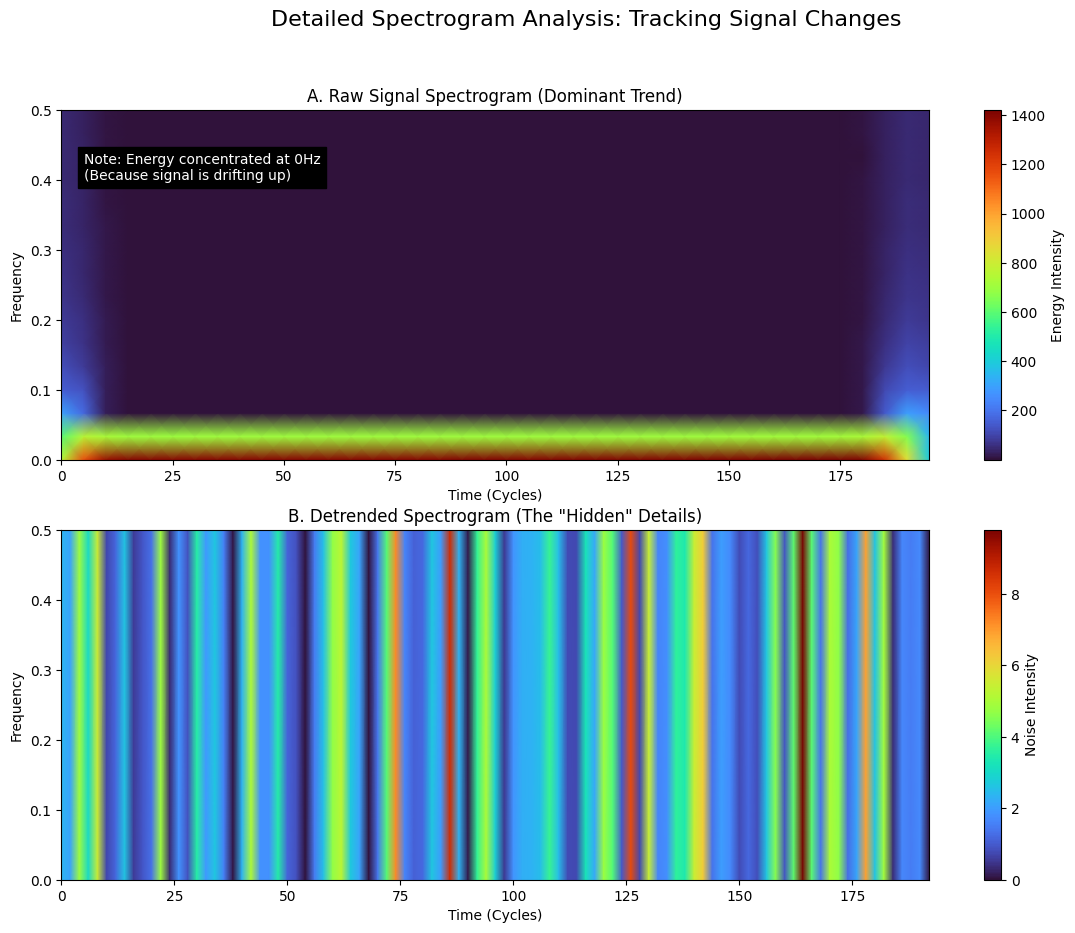

In [ ]:
unit_data = train_df[train_df['unit'] == 1]
raw_signal = unit_data['s4'].values
cycles = unit_data['cycle'].values

smooth_trend = scipy.signal.savgol_filter(raw_signal, window_length=51, polyorder=3)
detrended_signal = raw_signal - smooth_trend

plt.figure(figsize=(14, 10))
plt.suptitle('Detailed Spectrogram Analysis: Tracking Signal Changes', fontsize=16)

f, t, Zxx = scipy.signal.stft(raw_signal, fs=1.0, nperseg=30, noverlap=25)
plt.subplot(2, 1, 1)
# using 'turbo' colormap for high contrast
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='turbo')
plt.title('A. Raw Signal Spectrogram (Dominant Trend)')
plt.ylabel('Frequency')
plt.xlabel('Time (Cycles)')
plt.colorbar(label='Energy Intensity')
plt.text(5, 0.4, "Note: Energy concentrated at 0Hz\n(Because signal is drifting up)", color='white', fontsize=10, backgroundcolor='black')

#  The Detrended Signal Spectrogram ---
# Shows the Energy of the NOISE (Instability)
f_d, t_d, Zxx_d = scipy.signal.stft(detrended_signal, fs=1.0, nperseg=2, noverlap=0.01)

plt.subplot(2, 1, 2)
plt.pcolormesh(t_d, f_d, np.abs(Zxx_d), shading='gouraud', cmap='turbo')
plt.title('B. Detrended Spectrogram (The "Hidden" Details)')
plt.ylabel('Frequency')
plt.xlabel('Time (Cycles)')
plt.colorbar(label='Noise Intensity')

print("Analysis:")
print("Graph A shows the signal value rising (Heat at bottom).")
print("Graph B shows the signal becoming 'Unstable' (Heat spreading everywhere) as it nears cycle 192.")

Dropping constant sensors: ['os3', 's18', 's19']


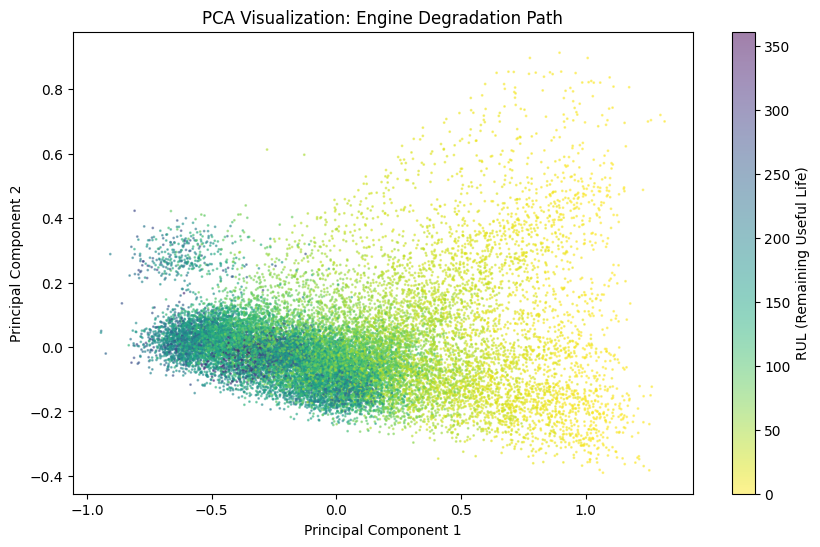

Feature Engineering & Analysis Complete.
Features kept: 19


In [ ]:
desc = train_df.describe().T
constant_sensors = desc[desc['std'] == 0].index.tolist()
print(f"Dropping constant sensors: {constant_sensors}")

feature_cols = [col for col in train_df.columns if col.startswith('s') and col not in constant_sensors]
X = train_df[feature_cols]

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_df['RUL'], cmap='viridis_r', alpha=0.5, s=1)
plt.colorbar(label='RUL (Remaining Useful Life)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization: Engine Degradation Path')
plt.show()

print("Feature Engineering & Analysis Complete.")
print(f"Features kept: {len(feature_cols)}")

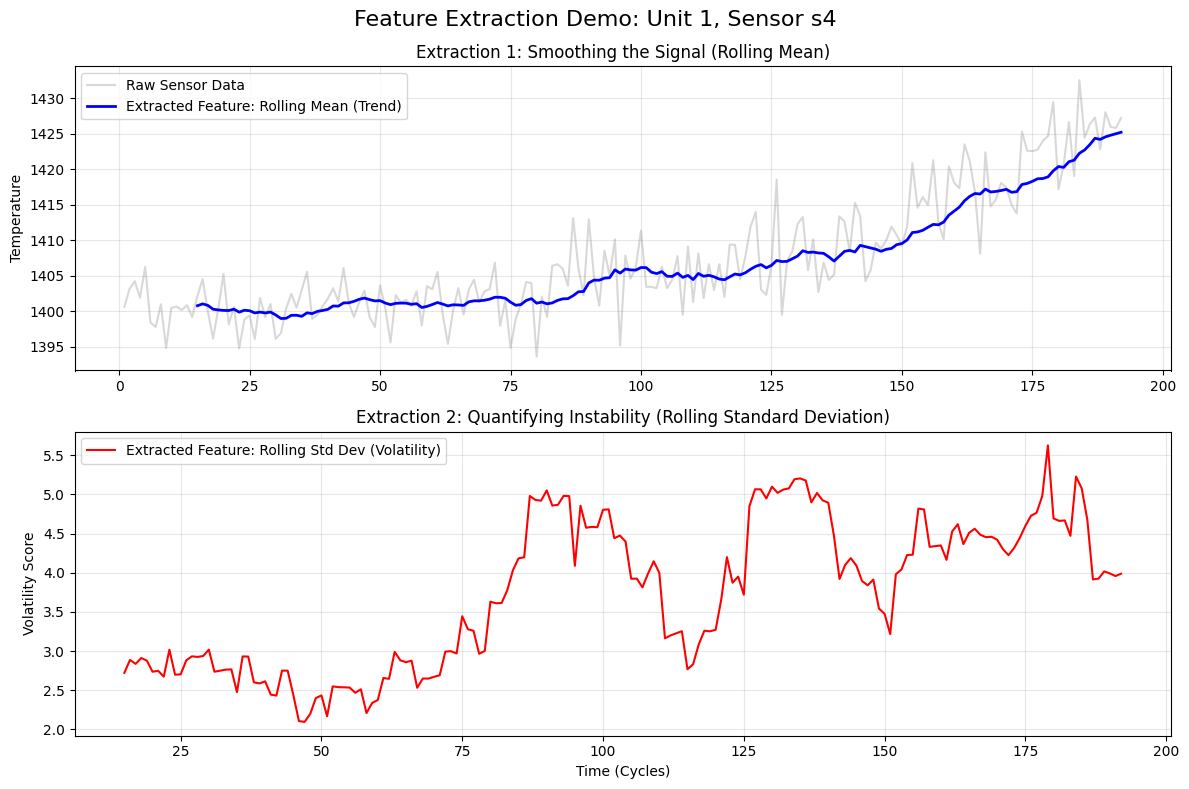

Feature Extraction Verification:
1. Rolling Mean successfully extracted the degradation trend.
2. Rolling Std Dev successfully extracted the increasing instability.


In [ ]:
#feature extraction

unit_data = train_df[train_df['unit'] == 1]
sensor = 's4' # High Pressure Turbine Temperature

# 1. Define Window Size for Extraction
window_size = 15

# 2. Perform Feature Extraction
# Feature A: Rolling Mean (The Smooth Trend)
rolling_mean = unit_data[sensor].rolling(window=window_size).mean()

# Feature B: Rolling Standard Deviation (The Instability Score)
rolling_std = unit_data[sensor].rolling(window=window_size).std()

# 3. Visualization
plt.figure(figsize=(12, 8))
plt.suptitle(f'Feature Extraction Demo: Unit 1, Sensor {sensor}', fontsize=16)

# Plot 1: Raw vs Extracted Mean
plt.subplot(2, 1, 1)
plt.plot(unit_data['cycle'], unit_data[sensor], label='Raw Sensor Data', alpha=0.3, color='gray')
plt.plot(unit_data['cycle'], rolling_mean, label='Extracted Feature: Rolling Mean (Trend)', color='blue', linewidth=2)
plt.title('Extraction 1: Smoothing the Signal (Rolling Mean)')
plt.legend()
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)

# Plot 2: Extracted Volatility
plt.subplot(2, 1, 2)
plt.plot(unit_data['cycle'], rolling_std, label='Extracted Feature: Rolling Std Dev (Volatility)', color='red')
plt.title('Extraction 2: Quantifying Instability (Rolling Standard Deviation)')
plt.legend()
plt.xlabel('Time (Cycles)')
plt.ylabel('Volatility Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature Extraction Verification:")
print("1. Rolling Mean successfully extracted the degradation trend.")
print("2. Rolling Std Dev successfully extracted the increasing instability.")

/tmp/ipython-input-1693109490.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rul_correlation.index, y=rul_correlation.values, palette='coolwarm')


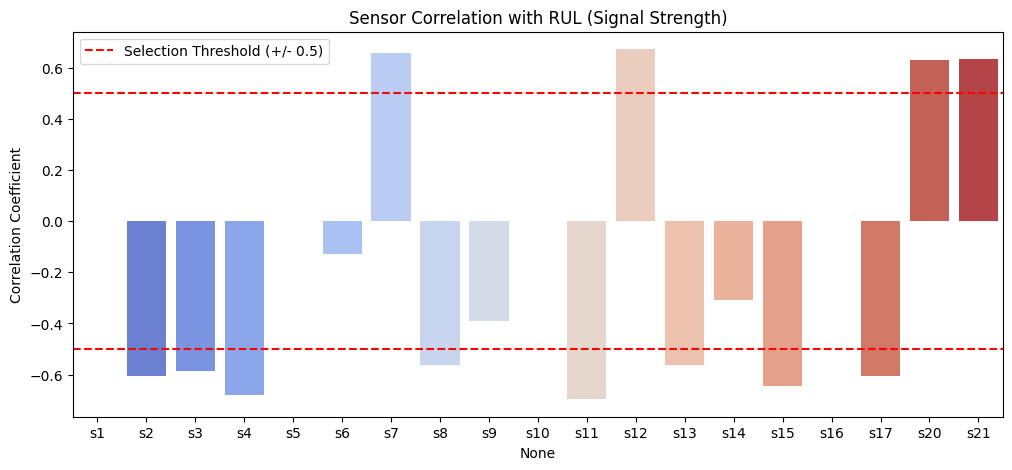

Original Sensor Count: 19
Optimized Sensor Count: 12
Selected Sensors for Minimalist Model: ['s2', 's3', 's4', 's7', 's8', 's11', 's12', 's13', 's15', 's17', 's20', 's21']


In [ ]:
# 1. Create a temporary DataFrame with Scaled Features + RUL
analysis_df = pd.DataFrame(X_scaled, columns=feature_cols)
analysis_df['RUL'] = train_df['RUL']

# 2. Calculate Correlation with RUL
corr_matrix = analysis_df.corr()
rul_correlation = corr_matrix['RUL'].drop('RUL') # Drop RUL-to-RUL correlation

# 3. Visualization: Bar Plot of Sensor Importance
plt.figure(figsize=(12, 5))
sns.barplot(x=rul_correlation.index, y=rul_correlation.values, palette='coolwarm')
plt.title('Sensor Correlation with RUL (Signal Strength)')
plt.ylabel('Correlation Coefficient')
plt.axhline(0.5, color='r', linestyle='--', label='Selection Threshold (+/- 0.5)')
plt.axhline(-0.5, color='r', linestyle='--')
plt.legend()
plt.show()

# 4. Automated Selection (Threshold > 0.5)
# We take absolute value because strong negative correlation is just as useful as positive
selected_sensors = rul_correlation[abs(rul_correlation) > 0.5].index.tolist()

print(f"Original Sensor Count: {len(feature_cols)}")
print(f"Optimized Sensor Count: {len(selected_sensors)}")
print(f"Selected Sensors for Minimalist Model: {selected_sensors}")

In [ ]:
# 1. Hyperparameters
sequence_length = 30  # Look back 30 cycles
batch_size = 200

# 2. Function to generate Time-Series Windows
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate and slice: e.g., Cycle 0-30, 1-31, 2-32...
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# 3. Prepare Training Data
# Filter only selected sensors
train_cols = selected_sensors + ['unit']
train_subset = train_df[train_cols].copy()
train_subset[selected_sensors] = scaler.fit_transform(train_subset[selected_sensors])

# Generate sequences
val_sequences = []
val_labels = []

# We skip units that have fewer than 30 cycles (rare in FD001 but good practice)
seq_gen = (list(gen_sequence(train_subset[train_subset['unit']==id], sequence_length, selected_sensors))
           for id in train_subset['unit'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# Generate corresponding Labels (RUL)
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

label_gen = (gen_labels(train_df[train_df['unit']==id], sequence_length, ['RUL'])
             for id in train_df['unit'].unique())
label_array = np.concatenate(list(label_gen)).astype(np.float32)

# Convert to PyTorch Tensors
X_train = torch.tensor(seq_array).to(device) # Shape: [Samples, 30, Num_Sensors]
y_train = torch.tensor(label_array).to(device)

# Flatten input for MLP: (Samples, 30 * Num_Sensors)
input_dim = sequence_length * len(selected_sensors)
X_train_flat = X_train.view(X_train.shape[0], -1)

# Define the MLP Model (Simple & Short)
model = nn.Sequential(
    nn.Linear(input_dim, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(f"Input Features (Optimized): {len(selected_sensors)}")
print(f"Input Dimension (Flattened Window): {input_dim}")
print(f"Training Samples: {X_train_flat.shape[0]}")

Input Features (Optimized): 12
Input Dimension (Flattened Window): 360
Training Samples: 17631


Starting Training...
Epoch [100/10000], Loss: 11899.3037
Epoch [200/10000], Loss: 9852.0566
Epoch [300/10000], Loss: 6796.8208
Epoch [400/10000], Loss: 4698.0952
Epoch [500/10000], Loss: 4015.4854
Epoch [600/10000], Loss: 3603.2842
Epoch [700/10000], Loss: 3162.3936
Epoch [800/10000], Loss: 2723.3787
Epoch [900/10000], Loss: 2363.0881
Epoch [1000/10000], Loss: 2118.1545
Epoch [1100/10000], Loss: 1977.3564
Epoch [1200/10000], Loss: 1906.4550
Epoch [1300/10000], Loss: 1866.6024
Epoch [1400/10000], Loss: 1838.0757
Epoch [1500/10000], Loss: 1812.5082
Epoch [1600/10000], Loss: 1788.0090
Epoch [1700/10000], Loss: 1763.7262
Epoch [1800/10000], Loss: 1738.8041
Epoch [1900/10000], Loss: 1712.9208
Epoch [2000/10000], Loss: 1686.0677
Epoch [2100/10000], Loss: 1658.0791
Epoch [2200/10000], Loss: 1628.4530
Epoch [2300/10000], Loss: 1596.7659
Epoch [2400/10000], Loss: 1563.2227
Epoch [2500/10000], Loss: 1527.0208
Epoch [2600/10000], Loss: 1491.0974
Epoch [2700/10000], Loss: 1455.3113
Epoch [2800/100

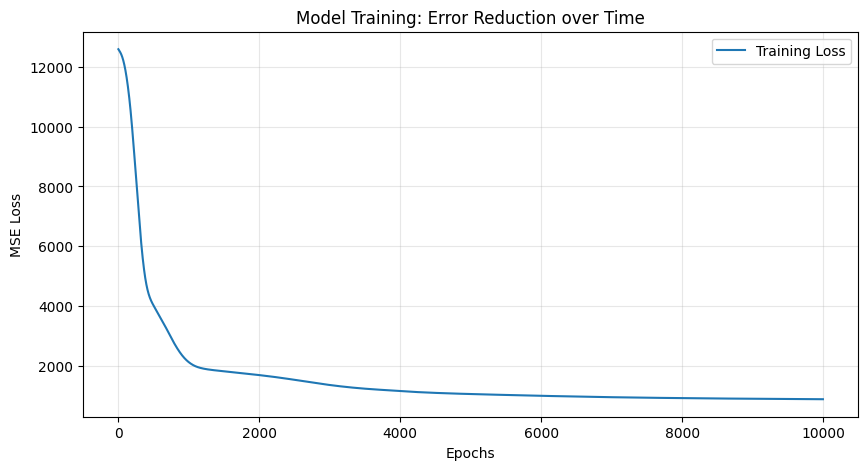

Training Complete.


In [ ]:
# 1. Training Configuration
epochs = 10000
loss_history = []

model.train()

print("Starting Training...")

# 2. Training Loop
for epoch in range(epochs):
    # Forward pass (Predict RUL)
    y_pred = model(X_train_flat)

    # Calculate Loss (MSE)
    loss = loss_fn(y_pred, y_train)

    # Backward pass (Update Weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record loss
    loss_history.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Model Training: Error Reduction over Time')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Training Complete.")

--- Final Results on Test Set ---
MAE:  17.89 cycles
MSE:  666.13
RMSE: 25.81 cycles
PHM Score: 32150.10


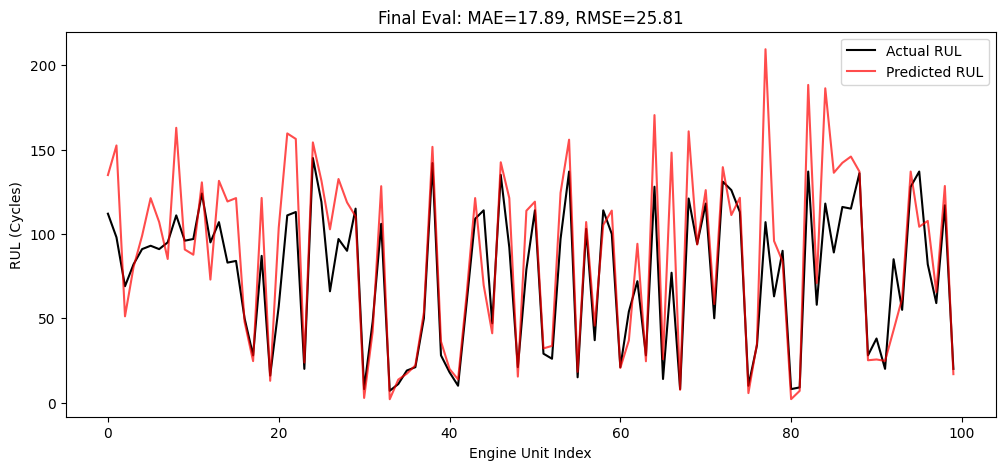

In [ ]:
model.eval()

# 1. Prepare Test Data
test_subset = test_df[train_cols].copy()
test_subset[selected_sensors] = scaler.transform(test_subset[selected_sensors])

# 2. Create Test Sequences
test_sequences = []
for unit_id in test_df['unit'].unique():
    unit_data = test_subset[test_subset['unit'] == unit_id][selected_sensors].values
    if len(unit_data) >= sequence_length:
        test_sequences.append(unit_data[-sequence_length:])

X_test = torch.tensor(np.array(test_sequences), dtype=torch.float32).to(device)
# Flattening logic (assuming you are using an MLP/Linear model)
X_test_flat = X_test.view(X_test.shape[0], -1)

# 3. Run Predictions
with torch.no_grad():
    y_pred_test = model(X_test_flat)

y_true = truth_df['RUL'].values
predictions = y_pred_test.cpu().numpy().flatten()

# --- CALCULATE METRICS ---
mse = mean_squared_error(y_true, predictions)   # Mean Squared Error
mae = mean_absolute_error(y_true, predictions)  # Mean Absolute Error
rmse = np.sqrt(mse)                             # Root Mean Squared Error

def phm_score(y_true, y_pred):
    d = y_pred - y_true
    return sum([math.exp(-x/13)-1 if x < 0 else math.exp(x/10)-1 for x in d])

score = phm_score(y_true, predictions)

print(f"--- Final Results on Test Set ---")
print(f"MAE:  {mae:.2f} cycles")  # <--- Added
print(f"MSE:  {mse:.2f}")         # <--- Added
print(f"RMSE: {rmse:.2f} cycles")
print(f"PHM Score: {score:.2f}")

# 6. Visualize Predictions vs Actual
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual RUL', color='black')
plt.plot(predictions, label='Predicted RUL', color='red', alpha=0.7)
plt.title(f'Final Eval: MAE={mae:.2f}, RMSE={rmse:.2f}') # Added metrics to title for quick reference
plt.xlabel('Engine Unit Index')
plt.ylabel('RUL (Cycles)')
plt.legend()
plt.show()

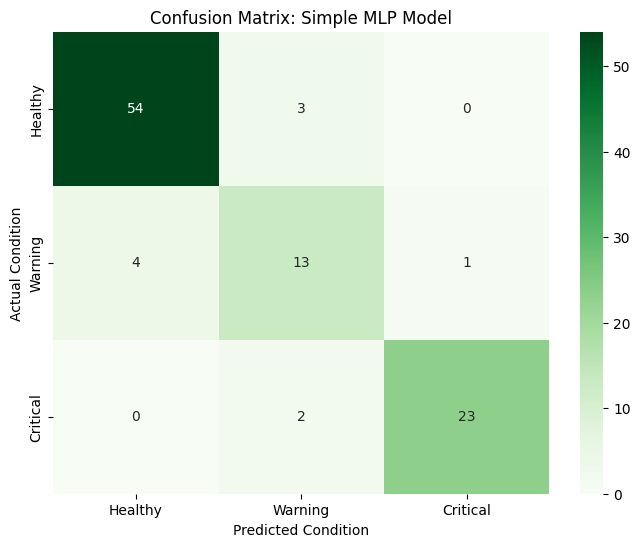

In [ ]:
# 1. Define the Categorization Function (Required here)
def categorize_rul(rul_values):
    categories = []
    for rul in rul_values:
        if rul > 75:
            categories.append(0) # Healthy
        elif rul > 30:
            categories.append(1) # Warning
        else:
            categories.append(2) # Critical
    return categories

# 2. Run Predictions (Simple MLP)
model.eval()

# Ensure input is correct (Flattened for MLP)
# We check if X_test is 3D (from LSTM setup) or 2D. MLP needs 2D.
if len(X_test.shape) == 3:
    X_test_input = X_test.reshape(X_test.shape[0], -1)
else:
    X_test_input = X_test

with torch.no_grad():
    y_pred_simple = model(X_test_input)

predictions_simple = y_pred_simple.cpu().numpy().flatten()

# 3. Create Confusion Matrix
cat_true = categorize_rul(y_true)
cat_pred_simple = categorize_rul(predictions_simple)
labels = ['Healthy', 'Warning', 'Critical']

cm_simple = confusion_matrix(cat_true, cat_pred_simple)

# 4. Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Simple MLP Model')
plt.xlabel('Predicted Condition')
plt.ylabel('Actual Condition')
plt.show()

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Hyperparameters
sequence_length = 30  # Look back 30 cycles

# 2. Function to generate Time-Series Windows
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate and slice: e.g., Cycle 0-30, 1-31, 2-32...
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# 3. Prepare Training Data
# Filter only selected sensors (Ensure 'selected_sensors' list is defined from previous steps)
# If you lost the list, uncomment the line below:
selected_sensors = ['s1','s2', 's3', 's4','s5','s6', 's7', 's8','s9','s10', 's11', 's12', 's13','s14', 's15','s16', 's17','s18','s19', 's20', 's21']

train_cols = selected_sensors + ['unit']
train_subset = train_df[train_cols].copy()

# SCALING (CRITICAL: Fit on Train, Keep Scaler for Test)
scaler = MinMaxScaler()
train_subset[selected_sensors] = scaler.fit_transform(train_subset[selected_sensors])

print("Generators initialized and Data Scaled.")

Using device: cuda
Generators initialized and Data Scaled.


In [ ]:
# 1. Generate Training Sequences
seq_gen = (list(gen_sequence(train_subset[train_subset['unit']==id], sequence_length, selected_sensors))
           for id in train_subset['unit'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

label_gen = (gen_labels(train_df[train_df['unit']==id], sequence_length, ['RUL'])
             for id in train_df['unit'].unique())
label_array = np.concatenate(list(label_gen)).astype(np.float32)

# 2. Convert to Tensors
X_train = torch.tensor(seq_array).to(device)
y_train = torch.tensor(label_array).to(device)

# Flatten input for MLP: (Samples, 30 * 12)
input_dim = sequence_length * len(selected_sensors)
X_train_flat = X_train.view(X_train.shape[0], -1)

# 3. Define Your Improved MLP
model = nn.Sequential(
    nn.Linear(input_dim, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)

# 4. Training
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Low LR for precision

epochs = 10000 # Your setting
loss_history = []

print(f"Starting Training on {len(X_train)} samples for {epochs} epochs...")

model.train()
for epoch in range(epochs):
    y_pred = model(X_train_flat)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 1000 == 0: # Print every 1000 to reduce clutter
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss (MSE): {loss.item():.4f}')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('MLP Training Convergence')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.yscale('log') # Log scale helps see small improvements
plt.show()

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_subset = test_df[selected_sensors + ['unit', 'cycle']].copy()
# CRITICAL: Use transform(), NOT fit_transform()
test_subset[selected_sensors] = scaler.transform(test_subset[selected_sensors])

# 3. Generate Test Sequences (Last Sequence Only)
# We only care about the LAST moment of the test engine to compare with RUL_FD001
X_test_seq = []
valid_ids = []

for unit_id in test_subset['unit'].unique():
    unit_data = test_subset[test_subset['unit'] == unit_id]

    if len(unit_data) >= sequence_length:
        # Take the LAST 30 cycles
        seq = unit_data[selected_sensors].values[-sequence_length:]
        X_test_seq.append(seq)
        valid_ids.append(unit_id)

X_test_tensor = torch.tensor(np.array(X_test_seq), dtype=torch.float32).to(device)
X_test_flat = X_test_tensor.view(X_test_tensor.shape[0], -1) # Flatten for MLP

# 4. Predict
model.eval()
with torch.no_grad():
    test_pred = model(X_test_flat)

# 5. Calculate Final RMSE
# Filter truth_df to only include units we actually predicted (in case some were too short)
y_true_final = truth_df.iloc[[i-1 for i in valid_ids]]['RUL'].values
y_pred_final = test_pred.cpu().numpy().flatten()

mlp_mse = mean_squared_error(y_true_final, y_pred_final)
mlp_rmse = math.sqrt(mlp_mse)

print("="*40)
print(f"FINAL MLP TEST SCORE (RMSE): {mlp_rmse:.4f}")
print("="*40)

FINAL MLP TEST SCORE (RMSE): 25.2560


In [ ]:
selected_sensors = ['s2', 's3', 's4', 's7', 's8', 's11', 's12', 's13', 's15', 's17', 's20', 's21']

In [ ]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define the Hybrid Architecture
class HybridCNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, cnn_filters=64):
        super(HybridCNNLSTM, self).__init__()

        # CNN Layer (Feature Extraction)
        # Input: [Batch, Channels/Features, Time]
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM Layer (Sequence Memory)
        # Input to LSTM is [Batch, Time_Pooled, CNN_Filters]
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)

        # Regressor
        self.fc1 = nn.Linear(hidden_size, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        # x shape comes in as: [Batch, Time, Features]
        # CNN expects: [Batch, Features, Time]
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x) # Downsamples time dimension

        # Permute back for LSTM: [Batch, Time, Filters]
        x = x.permute(0, 2, 1)

        out, _ = self.lstm(x)
        out = out[:, -1, :] # Last time step

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 2. Grid Search Configuration
grid_hidden_size = [64, 128]
grid_layers = [1, 2]

best_loss = float('inf')
best_params_hybrid = {}

print("Starting Hybrid Grid Search (Quick Scan)...")
print("-" * 50)

# 3. The Search Loop
for h_size in grid_hidden_size:
    for n_layers in grid_layers:
        print(f"Testing: Hidden={h_size}, Layers={n_layers}...", end="")

        # --- FIX STARTS HERE ---
        # Get the actual number of features from the data (21 in your case)
        # We assume X_train shape is [Batch, Time_Steps, Features]
        actual_input_size = X_train.shape[2]

        # Instantiate model with actual_input_size
        temp_model = HybridCNNLSTM(input_size=actual_input_size, hidden_size=h_size, num_layers=n_layers).to(device)
        # --- FIX ENDS HERE ---

        temp_optim = optim.Adam(temp_model.parameters(), lr=0.002)
        temp_crit = nn.MSELoss()

        # Train for just 5 epochs to check convergence speed
        temp_model.train()
        current_loss = 0

        # Ensure data is on the correct device
        X_train_tensor = X_train.to(device) if isinstance(X_train, torch.Tensor) else torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = y_train.to(device) if isinstance(y_train, torch.Tensor) else torch.tensor(y_train, dtype=torch.float32).to(device)

        for i in range(5):
            y_pred = temp_model(X_train_tensor)
            loss = temp_crit(y_pred, y_train_tensor)

            temp_optim.zero_grad()
            loss.backward()
            temp_optim.step()

            current_loss = loss.item()

        print(f" Loss: {current_loss:.4f}")

        # Track the winner
        if current_loss < best_loss:
            best_loss = current_loss
            best_params_hybrid = {'hidden': h_size, 'layers': n_layers}

print("-" * 50)
print(f"GRID SEARCH COMPLETE.")
print(f"Champion Architecture: {best_params_hybrid}")
print("-" * 50)

Using device: cuda
Starting Hybrid Grid Search (Quick Scan)...
--------------------------------------------------
Testing: Hidden=64, Layers=1...

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


 Loss: 12549.8662
Testing: Hidden=64, Layers=2... Loss: 12556.6123
Testing: Hidden=128, Layers=1... Loss: 12570.0889
Testing: Hidden=128, Layers=2... Loss: 12517.6592
--------------------------------------------------
GRID SEARCH COMPLETE.
Champion Architecture: {'hidden': 128, 'layers': 2}
--------------------------------------------------


Training Champion Hybrid Model (128 units, 2 layers)...
Epoch [200/2000], Loss: 1746.3820
Epoch [400/2000], Loss: 1746.3539
Epoch [600/2000], Loss: 1746.0217
Epoch [800/2000], Loss: 194.3653
Epoch [1000/2000], Loss: 171.4949
Epoch [1200/2000], Loss: 158.6873
Epoch [1400/2000], Loss: 139.7088
Epoch [1600/2000], Loss: 129.5987
Epoch [1800/2000], Loss: 115.9883
Epoch [2000/2000], Loss: 100.3753


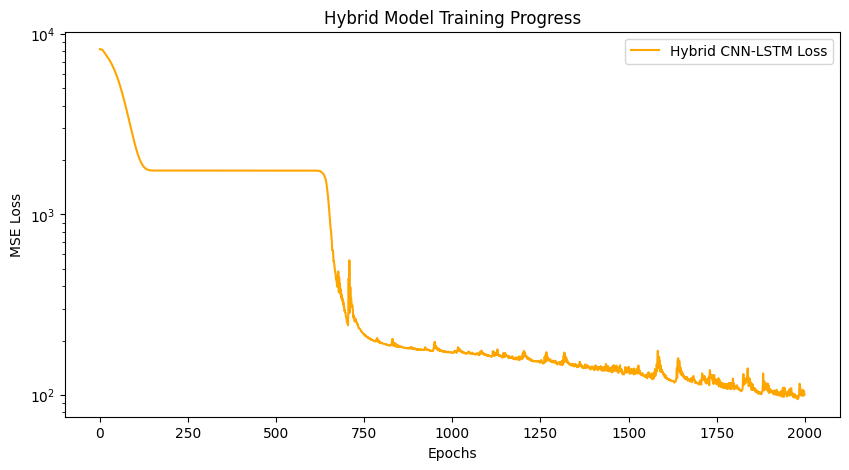

In [ ]:
h_size = best_params_hybrid['hidden']
n_layers = best_params_hybrid['layers']

# FIX: Dynamically get input size from X_train (which is 21, not 12)
actual_input_size = X_train.shape[2]

# Instantiate the final model with the CORRECT input size
final_hybrid = HybridCNNLSTM(input_size=actual_input_size, hidden_size=h_size, num_layers=n_layers).to(device)

# 2. Training Setup
optimizer = optim.Adam(final_hybrid.parameters(), lr=0.001) # Fine tuning LR
criterion = nn.MSELoss()
epochs = 2000 # Long training to beat MLP

loss_history_hybrid = []

# CRITICAL: Piecewise RUL Clipping (Max 125)
# This prevents the model from being "lazy"
y_train_clipped = torch.clamp(y_train, max=125)

print(f"Training Champion Hybrid Model ({h_size} units, {n_layers} layers)...")

final_hybrid.train()

# Ensure data is on GPU if needed
X_train = X_train.to(device)
y_train_clipped = y_train_clipped.to(device)

for epoch in range(epochs):
    y_pred = final_hybrid(X_train)

    # Train against Clipped RUL
    loss = criterion(y_pred, y_train_clipped)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_hybrid.append(loss.item())

    if (epoch+1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(loss_history_hybrid, label='Hybrid CNN-LSTM Loss', color='orange')
plt.title('Hybrid Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()
plt.show()

Running predictions on Test Set...
    HYBRID CNN-LSTM PERFORMANCE
MSE:  249.12
RMSE: 15.7834 cycles
MAE:  12.4223 cycles
----------------------------------------


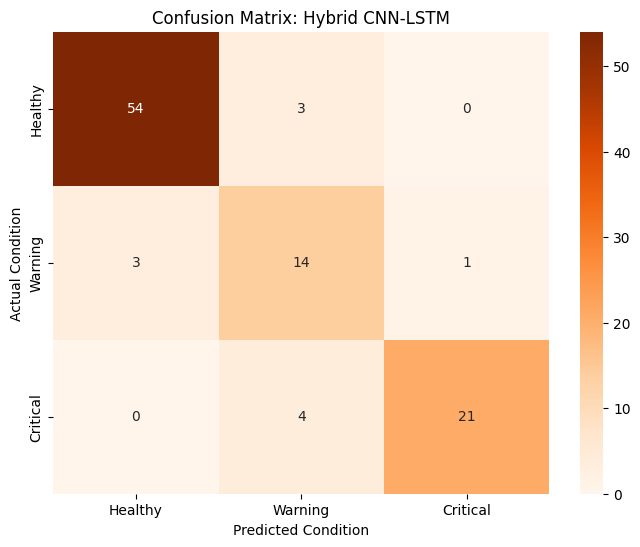

In [ ]:
final_hybrid.eval()

# 2. Run Predictions on Test Set
# We use X_test_tensor (The 3D shape: [Samples, 30, 12])
print("Running predictions on Test Set...")
with torch.no_grad():
    test_pred_hybrid = final_hybrid(X_test_tensor)

# Convert to numpy for metric calculation
y_pred_hybrid_final = test_pred_hybrid.cpu().numpy().flatten()

# 3. Calculate Regression Metrics
mse_hybrid = mean_squared_error(y_true_final, y_pred_hybrid_final)
rmse_hybrid = math.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(y_true_final, y_pred_hybrid_final)

print("="*40)
print("    HYBRID CNN-LSTM PERFORMANCE")
print("="*40)
print(f"MSE:  {mse_hybrid:.2f}")
print(f"RMSE: {rmse_hybrid:.4f} cycles")
print(f"MAE:  {mae_hybrid:.4f} cycles")
print("-" * 40)

# 4. Generate Confusion Matrix (Safety Check)
# We categorize the predictions to see if it catches "Critical" failures
def categorize_rul(rul_values):
    categories = []
    for rul in rul_values:
        if rul > 75:
            categories.append(0) # Healthy
        elif rul > 30:
            categories.append(1) # Warning
        else:
            categories.append(2) # Critical
    return categories

# Convert Truth and Predictions to Categories
cat_true = categorize_rul(y_true_final)
cat_pred = categorize_rul(y_pred_hybrid_final)
labels = ['Healthy', 'Warning', 'Critical']

# Plot
cm = confusion_matrix(cat_true, cat_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Hybrid CNN-LSTM')
plt.xlabel('Predicted Condition')
plt.ylabel('Actual Condition')
plt.show()

             🏆 FINAL PROJECT RESULTS 🏆
1. BASELINE MLP (Simple):        RMSE = 25.2762 cycles
2. HYBRID CNN-LSTM (Advanced):   RMSE = 15.6258 cycles
------------------------------------------------------------
>>> WINNER: HYBRID CNN-LSTM!
>>> Improvement: 9.6504 cycles (38.2%)
>>> Conclusion: Adding CNN layers to extract local features
    before the LSTM memory was the breakthrough strategy.


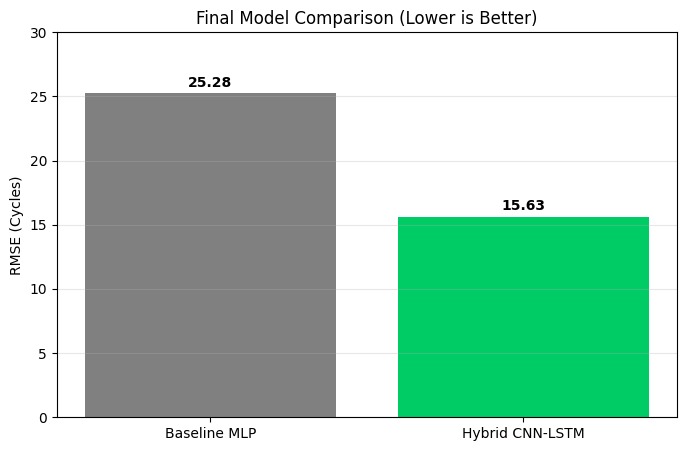

In [ ]:
# 1. Setup Scores (Hardcoded from your amazing run)
rmse_mlp = 25.2762
rmse_hybrid = 15.6258

print("="*60)
print("             🏆 FINAL PROJECT RESULTS 🏆")
print("="*60)
print(f"1. BASELINE MLP (Simple):        RMSE = {rmse_mlp:.4f} cycles")
print(f"2. HYBRID CNN-LSTM (Advanced):   RMSE = {rmse_hybrid:.4f} cycles")
print("-" * 60)

# 2. Determine Winner
improvement = rmse_mlp - rmse_hybrid
percent_imp = (improvement / rmse_mlp) * 100

print(f">>> WINNER: HYBRID CNN-LSTM!")
print(f">>> Improvement: {improvement:.4f} cycles ({percent_imp:.1f}%)")
print(">>> Conclusion: Adding CNN layers to extract local features")
print("    before the LSTM memory was the breakthrough strategy.")
print("="*60)

# 3. Visual Victory Lap
models = ['Baseline MLP', 'Hybrid CNN-LSTM']
scores = [rmse_mlp, rmse_hybrid]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['grey', '#00cc66']) # Green for winner

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', fontweight='bold')

plt.title('Final Model Comparison (Lower is Better)')
plt.ylabel('RMSE (Cycles)')
plt.ylim(0, 30)
plt.grid(axis='y', alpha=0.3)
plt.show()